In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the data
path = '1661-0.txt'
text = open(path,encoding = "utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [3]:
#Data Preprocessing
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [4]:
#chunk 40 characters with 3 sequences
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [5]:
# generating our features and labels
#one hot encoding
X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
y = np.zeros((len(sentences), len(character)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

In [6]:
print("X shape:",X.shape)
print("Y shape:",y.shape)


X shape: (193950, 40, 73)
Y shape: (193950, 73)


In [7]:
# Creating the model
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


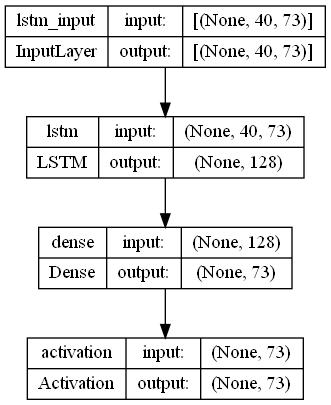

In [8]:
plot_model(model, show_shapes=True, to_file='model.png')

In [9]:
# Training our model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=10, 
                    shuffle=True).history

Epoch 1/10
1501/1501 [==============================] - 91s 59ms/step - loss: 1.9669 - accuracy: 0.4227 - val_loss: 2.1715 - val_accuracy: 0.4041
Epoch 2/10
1501/1501 [==============================] - 90s 60ms/step - loss: 1.6202 - accuracy: 0.5159 - val_loss: 2.0235 - val_accuracy: 0.4459
Epoch 3/10
1501/1501 [==============================] - 97s 64ms/step - loss: 1.5212 - accuracy: 0.5427 - val_loss: 1.9656 - val_accuracy: 0.4613
Epoch 4/10
1501/1501 [==============================] - 98s 65ms/step - loss: 1.4688 - accuracy: 0.5567 - val_loss: 1.9631 - val_accuracy: 0.4820
Epoch 5/10
1501/1501 [==============================] - 94s 63ms/step - loss: 1.4360 - accuracy: 0.5648 - val_loss: 1.9577 - val_accuracy: 0.4768
Epoch 6/10
1501/1501 [==============================] - 94s 62ms/step - loss: 1.4104 - accuracy: 0.5723 - val_loss: 1.9661 - val_accuracy: 0.4773
Epoch 7/10
1501/1501 [==============================] - 89s 60ms/step - loss: 1.3920 - accuracy: 0.5773 - val_loss: 1.9712 -

In [11]:
#Model Evaluation
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])
     

6061/6061 [==============================] - 67s 11ms/step - loss: 1.3059 - accuracy: 0.5989
Test Loss 1.3058940172195435
Test Accuracy 0.5988553762435913


In [13]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)



def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion
        
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
#Prediction
quotes = [   
    "Deep learning is subset of machine learnin",
    "i like "]

In [ ]:

for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is subset of machine learn
[' and ', 'ed ', 'ing ', 't ', 's ']

i li
